## Estimate Posterior using MCMC
study group tutorial 16jan19 / jplewis

In [9]:
using PyPlot
p_ = PyPlot

PyPlot

### test out Distributions package

In [10]:
using Distributions
normal = Distributions.Normal(0., 1.0 )
Distributions.pdf(normal,1.5)
noisesigma = 0.1
noise = Distributions.Normal(0., noisesigma)
gaussian(val,μ,σ) = (1. /sqrt(2. * π * σ^2 )) * exp( - (val-μ)^2 / (2. * σ^2))
(gaussian(2.3,0,noisesigma), Distributions.pdf(noise,2.3))
(gaussian(-0.3,0,noisesigma), Distributions.pdf(noise,-0.3))   # same

(0.044318484119380115, 0.044318484119380115)

### model

A,B ~ N(0,1)

$y = A x + B + \epsilon$

### true parameter values

In [16]:
N = 5  # data points
A = randn()
B = randn()
(A,B)

(-0.6712765616772629, -0.14603001704769042)

### Generate sample data

In [17]:
ϵ = noisesigma * randn(N,)   # todo use Distributions package sample
x = 2. * randn(N,)
y = A * x .+ B .+ ϵ

5-element Array{Float64,1}:
  1.4419528830708923 
  1.3481759747319904 
 -1.8216983358841983 
  0.21393419323847113
 -0.7733298943204574 

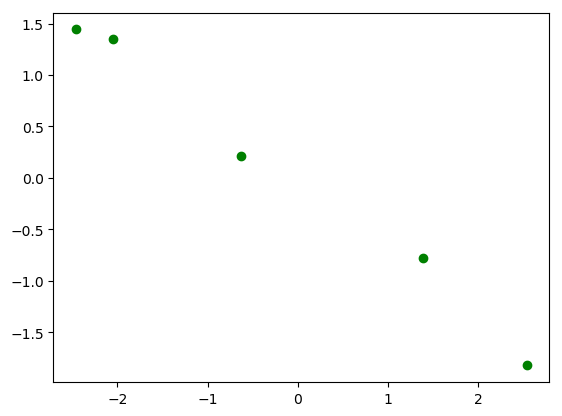

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x146125f28>

In [18]:
p_.plot(x,y,"go")

### Note likelihood (and improper prior) cancel
$$
    p(M|D) = \frac{ p(D|M) p(M)   }{ p(D)  } = \frac{ p(D|M) p(M)   }{ \int p(D|M) p(M) \, dM   }
$$

\begin{align*}
P(\theta|y,x) &= \frac{P(\theta,y,x)}{ P(y,x) }
\\
    &= \frac{ P(y|x,\theta) P(x|\theta) P(\theta) }{ P(y|x) P(x)  }
\\
    P(x|\theta) = P(x) \quad\text{and cancel}  &
\\
    &=  \frac{ P(y|x,\theta) P(\theta) }{ P(y|x) }
\\
\end{align*}

Posterior odds

\begin{align*}
   \frac{ P(\theta_1|y,x) }{ P(\theta|y,x) } &=   \frac{ \frac{ P(y|x,\theta_1) P(\theta_1) }{ P(y|x) } }{ \frac{ P(y|x,\theta) P(\theta) }{ P(y|x) } }     \quad=\quad  \frac{ P(y|x,\theta_1) P(\theta_1) }{  P(y|x,\theta) P(\theta)  }
\end{align*}

$$
P(y|x,\theta) = \prod \frac{1}{\sqrt 2 \pi \sigma^2} \exp(- |y_i - (a x_i + b)|^2 / (2 \sigma^2) 
$$

log likelihood = 

$$ 
-\frac{N}{2}\log(2 \pi \sigma^2) \quad-\quad  \left( \sum |y_i - (a x_i + b)|^2 / (2\sigma^2) \right) 
$$

(details)

\begin{align*}
&   \log \frac{1}{\sqrt{2 \pi \sigma^2}}
\\
&= \log 1  - \log ( 2 \pi \sigma^2 )^{1/2}
 \\
&=   0  - \frac{1}{2} \log{ 2 \pi \sigma^2}
\end{align*}

In [1]:
function loglikelihood(a,b)
    noisesigma2 = noisesigma*noisesigma
    ll = 0.
    for ipt = 1:N
        #print("  datapoint $ipt ")
        err = y[ipt] - (a*x[ipt]+b)
        peval = err*err / (2*noisesigma2)
        #print(" p0eval=",peval)
        ll -= peval
    end 
    ll -= (N/2.)*log(2*π*noisesigma2)
    ll
end

loglikelihood (generic function with 1 method)

In [22]:
function logposterior(a,b)
    useprior = false   # else improper/flat prior
    prior = 0.
    if useprior
        prior -= Distributions.pdf(normal,a)
        prior -= Distributions.pdf(normal,b)
    end
    prior + loglikelihood(a,b)
end

logposterior (generic function with 1 method)

Stopping test, log version

$$
\frac{ \exp(n)}{\exp(d)} > 1  \quad\rightarrow\quad   n - d > 0 
$$

In [23]:
function mcmc1logposterior(a,b)
    println("mcmc1logposterior initial $a $b")
    
    logposterior0 = logposterior(a,b)
    
    for mciter = 1:100
        if ((mciter%10)==0) println("  mciter $mciter")  end
        a_ = a + 0.5 * randn()
        b_ = b + 0.5 * randn()       # new proposal
        
        logposterior1 = logposterior(a_,b_)
        
        #println("logp1 $logposterior1,   logp0 $logposterior0")

        p = exp(logposterior1) / exp(logposterior0)
        if (rand() < p)
            println("\nsuccess $a_, $b_")
            return (a_,b_)
        else
            print(".")
        end   
    end
    println("")
    return (a,b)
end

mcmc1logposterior (generic function with 1 method)

In [24]:
function warmup(a,b) 
    for iter = 1:1000 
        if ((iter%10)==0) println("iter $iter")  end
        a,b = mcmc1logposterior(a,b)   
    end
    return (a,b)
end                # warmup


warmup (generic function with 1 method)

In [25]:
function mcmcline(a,b)
    aavg, bavg = (0.,0.)
    Niter = 100000
    for iter = 1:Niter 
        if ((iter%10)==0) println("iter $iter")  end
        a,b = mcmc1logposterior(a,b)   
        aavg += a
        bavg += b
    end
    aavg /= float(Niter)
    bavg /= float(Niter)
    return (aavg,bavg)
end

mcmcline (generic function with 1 method)

In [ ]:
# initial posterior estimate
a_, b_ = 0.,0.

a_, b_ = warmup(a_,b_)
aest, best = mcmcline(a_,b_)

print("estimate $aest, $best,   true $A, $B")

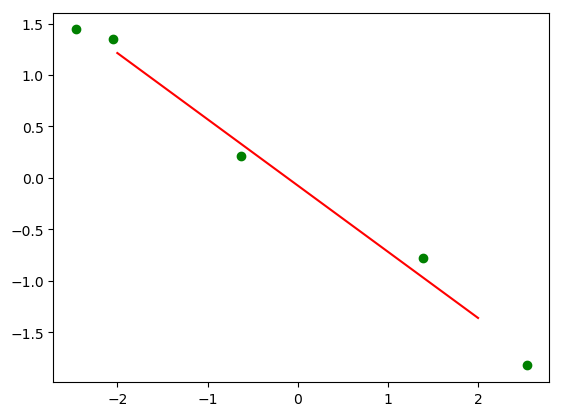

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1467ec908>

In [28]:
xx = [-2., 2.]
yy = aest .* xx .+ best
p_.plot(xx,yy,"r-")
p_.plot(x,y,"go")